# pyLLE example - Ring Resonator comb simulation

## Import and Setup 

Let's start by importing the package

In [1]:
import pyLLE

We now define the resonator parameters.

In [2]:
res = {'R': 23e-6, # ring radius in meter
       'Qi': 1e6,  # Intrinsic Q factor
       'Qc': 1e6,  # Coupled Q factor
       'γ': 1.55,  # Non-linear coefficient at the pump frequency
       'dispfile': 'TestDispersion.txt', # frequency and corresponding azymuthal mode simulated previously
      } 

We now define the simulation parameters. Here we precise a linear detuning ramp of the pump from **&delta;&omega;\_init** to **&delta;&omega;\_end** relative to the pump mode angular frequency, mode closest to the defined pump frequency **f\_pmp**. The simulation length **Tscan** is in unit of round trip, as it is more convenient in the Lugiato-Lefever formalism. It is important to notice that two parameters for the mode bandwidth have to be defined, **&mu;\_fit** which determined the fit window of the raw data found in **dispfile**, and **&mu;\_sim** which is the number of mode simulated in the LLE, hence could be larger than the fit mode through extrapolation

In [3]:
import numpy as np
sim = {'Pin': 150e-3, # Input power in Q
       'Tscan': 1e6,  # Length of the simulation in unit of round trip 
       'f_pmp': 191e12, # Pump Frequency 
       'δω_init': 2e9*2*np.pi, # Initial detuning of the pump in rad/s 
       'δω_end': -8e9*2*np.pi,  # End detunin of the pump in rad/s
       'μ_sim': [-74,170],  # azimuthal mode to simulate on the left and right side of the pump
       'μ_fit': [-71, 180], # azimuthal mode to fit the dispersion on the left and right side of the pump
        }

In both the resonator and simulation dictionaries, the parameters can be called through their greek letters or through their equivalent latin names (_e.g._ &mu;&nbsp;&rarr;&nbsp;mu or &delta;&omega;&nbsp;&rarr;&nbsp;deltaomega). A translator dictionnary is implemented to translates every greek entries (see. self._greek)

------

Let's initialize the class

In [4]:
solver = pyLLE.LLEsovler(sim=sim,
                       res=res,
                       debug=True)

## Dispersion Analyse

To plot and retrieve all the data of the dispersion, the method _self.Analyze_ has to be called, resulting in the plot of the integrated dispersion D<sub>int</sub>

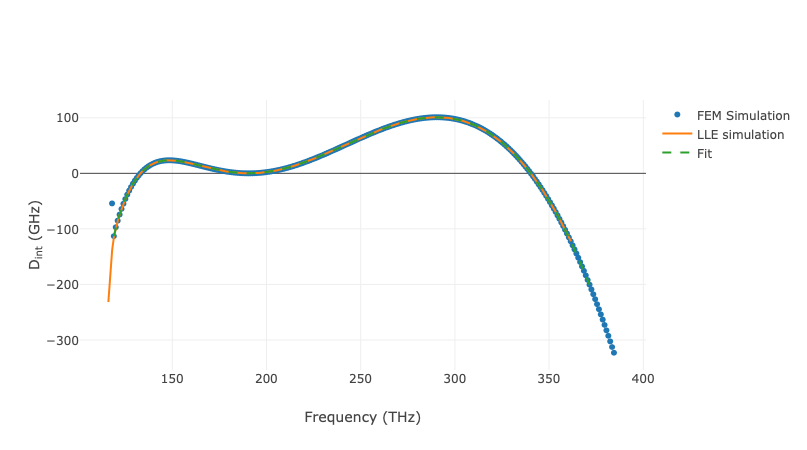

-- Dispersion Analysis --
	Pump index: 72
	Center Pump: 190.523 THz
	FSR: 1006.36 GHz
	D2: 24.58 MHz



In [5]:
solver.Analyze(plot=True,
               plottype='all')

One can clearly see that because we simulate a larger window  with the LLE (orange curve - _LLE simulation_) than the raw data (blue dots), we extrapolate outside of this region. One has to be carefull about this feature as ripple in the integrated dispersion can happen causing zero-crossings which are artefacts

---

A new attribute _disp_ has been created which consists of a dictionary of the different value of the retrieve dispersion

In [6]:
solver.disp.keys()

dict_keys(['freq', 'ng', 'neff', 'D', 'Dint', 'dphi'])

## Temporal Solver

One can solver the full temporal Lugiato Lefever equation :

$t_R \frac{\partial E(t, \tau)}{\partial t} = - \left(\frac{\alpha'}{2} - i\delta_0 \right)E + i \cdot \mathrm{FT}^{-1}\left[ -t_R D_{int}(\omega) \cdot \mathrm{FT}\left[E(t, \tau)\right]\right] + \gamma|E|^2 E  + \sqrt{\theta}E_{in}$

The solver implemented in this package is based on a Julia core called through python. Hence to interface both language in an easy way, a hdf5 file is created in a temporary location with all the necessary data to solve the above LLE. 

Hence, to solver the LLE here, we first need to setup the file:



In [ ]:
solver.Setup()

-- Solving standard LLE --
	Simulation Parameters
		R = 23.00 µm
		Qi = 1.00 M
		Qc = 1.00 M
		γ = 1.55 
	Simulation Parameters
		Pin = 150.00 mW
		Tscan = 1.00 x1e6 Round Trip
		f_pmp = 191.00 THz
		δω_init = 2.00 x2π GHz
		δω_end = -8.00 x2π GHz
		μ_sim = [-74.00,170.00] 
		μ_fit = [-71.00,180.00] 



----

And now we can solve the equation

In [ ]:
solver.SolveTemporal()

----------------------------------------------------------------------
2018-11-15 14:34:40
Launching Julia: Done
Computing LLE [******************************************        ] 85%

It is important to note that a KeyboardInterupt will result in killing the Julia process

----

When done, we need to retrieve the data

In [ ]:
solver.RetrieveData()

## Post Process of Temporal Solver

### Displaying Results

We can plot the first figure that gives an overall idea of the behavior of the resonator

In [ ]:
fig_sol = solver.PlotCombPower()

To have a better idea of what happen for a given detuning we can plot the spectra and the temporal profile of the electric field in the resonator

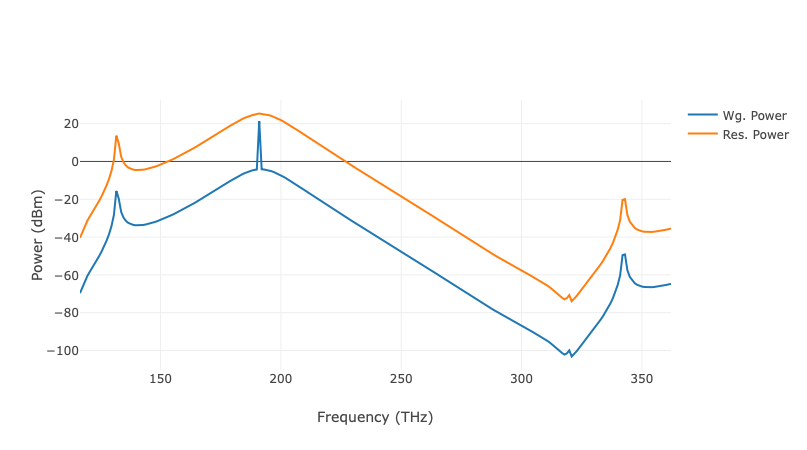

In [12]:
ind = 692
_ = solver.PlotCombSpectra(ind)

The temporal profile can also be retrieve, interesting in a case of we are on a soliton state for the given detuning

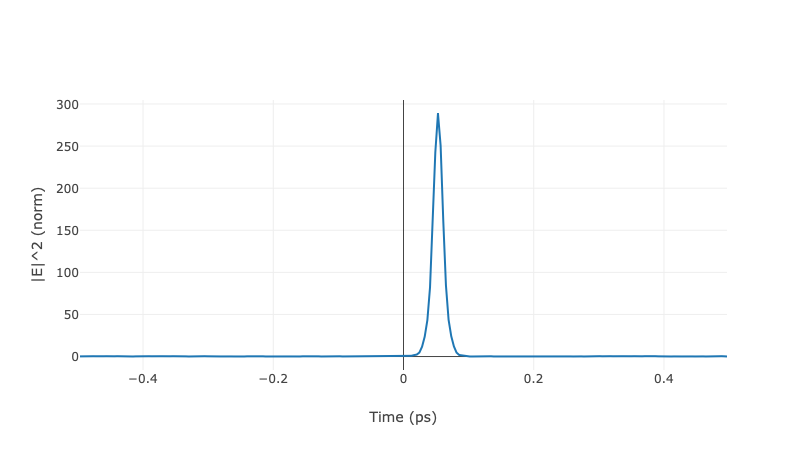

In [13]:
_ = solver.PlotSolitonTime(ind)

### Saving figures

Helper to save the figures, in any format supported by matplotlib have been created. The helper (_pylle.\_llesolver\_Latexify_) has been designed to make "publication-ready-like" figure, while one is using jupyter notebook/jupyter lab (hence reliying on plotly for figure display) or through a python consol (hence thorugh matplotlib display). Depending on which type of plot has already been display (comb summary, comb spectra, time profile), this figures will be saved in the specified format

In [ ]:
solver.SavePlots2File(basename = 'images/', format = 'pdf')
solver.SavePlots2File(basename = 'images/', format = 'png')

### Pickling the solver

The whole package has been design with simplicity in mind, which mean sinplicity to compute but also simplicity to retrieve results. Hence pyLLE is coded in a way that, using the _pickle_ package, one can easily save the state of the solver and retrieve it later, with all the feature presented above still available. It is important to use the _self.SaveResults_ method to pickle the solver as it takes care of dumping the different thread that cannot be pickle in the class.

In [15]:
solver.SaveResults('PickleSolver', path = './')

./PickleSolver.pkl


One can reload the state of the simualtion: 

In [1]:
import pickle as pkl
oldSolver = pkl.load(open('PickleSolver.pkl', 'br'))

The different methods can be called with the loaded pickled solver

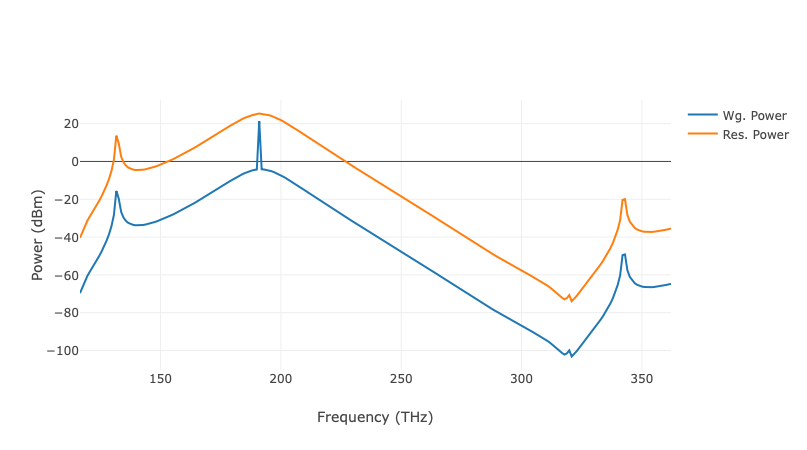

In [2]:
figly = oldSolver.PlotCombSpectra(692)

## Steady state Solver

One can solver the steady state Lugiato Lefever equation :

$- \left(\frac{\alpha'}{2} - i\delta_0 \right)E + i \cdot \mathrm{FT}^{-1}\left[ -t_R D_{int}(\omega) \cdot \mathrm{FT}\left[E(t, \tau)\right]\right] + \gamma|E|^2 E  + \sqrt{\theta}E_{in} = 0$

Using a Newton method to find the root of the equation will result in solvin this particular state of the LLE. 

The method _self.SolveSteadySteate_ is design for this. 

Although, it gives fast results, the accuracy of such solver remains questionable compare to a full temporal resolution of the equation

----

First we need to change the simulation parameters to introduce a fixe detuning &delta;&omega;

In [18]:
solver.sim['δω'] = -5e9*2*np.pi # more or less what it is as the end of the soliton step 

----------------------------------------------------------------------
2018-10-10 15:02:47
Not symmetric mode calculation -> switching to it with µ_sim = [-170, 170]

-- Dispersion Analysis --
	Pump index: 72
	Center Pump: 190.523 THz
	FSR: 1006.36 GHz
	D2: 24.58 MHz



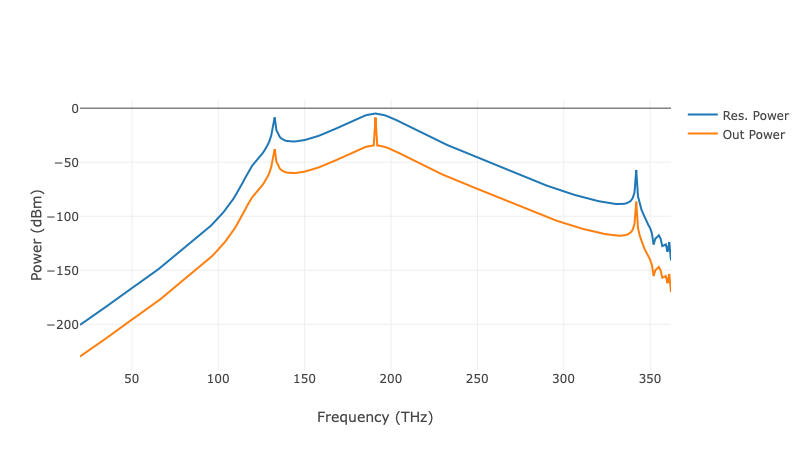

In [19]:
steady_fig = solver.SolveSteadySteate()

In [16]:
import plotly
plotly.plotly.plot(fig_sol)

/Users/greg/anaconda/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow



The draw time for this plot will be slow for clients without much RAM.


'https://plot.ly/~gmoille/41'